In [118]:
import splitwavepy as sw
import numpy as np
import math
import matplotlib.pyplot as plt

In [131]:
dat = sw.Data(delta=0.1, noise=0.01, split=(30, 1.3))
x0 = dat.x
y0 = dat.y

In [132]:
def rotate(x,y,degrees):
    """row 0 is x-axis and row 1 is y-axis,
       rotates from x to y axis
       e.g. N to E if row 0 is N cmp and row1 is E cmp"""
    ang = math.radians(degrees)
    rot = np.array([[ np.cos(ang), np.sin(ang)],
                    [-np.sin(ang), np.cos(ang)]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def rot2(x, y, deg):
    ang = math.radians(deg)
    cang = math.cos(ang)
    sang = math.sin(ang)
    rot = np.array([[ cang, sang],
                    [-sang, cang]])
    xy = np.dot(rot, np.vstack((x,y)))
    return xy[0], xy[1]

def get_c(dx, dy):
    c = np.empty((2, 2))
    c[0][0] = np.sum(dx**2)
    c[0][1] = c[1][0] = np.sum(dx*dy)
    c[1][1] = np.sum(dy**2)
    return c / (np.sqrt(c[0][0]) * np.sqrt(c[1][1]))

def slagchop(x, y, w0, w1, slag):
    d = int(slag/2)
    return x[w0+d: w1+d], y[w0-d: w1-d] 

def running_mean(x, w0, w1, slags):
    d = int(slags[-1]/2)
    x = x[w0-d: w1+d]
    n = w1-w0
    return np.convolve(x, np.ones((n,))/n, mode='valid')

# slower
# def running_mean2(x, w0, w1, maxslag):
#     d = int(maxslag/2)
#     x = x[w0-d: w1+d]
#     n = w1-w0
#     cumsum = np.cumsum(np.insert(x, 0, 0))
#     return (cumsum[n:] - cumsum[:-n]) / float(n)


In [191]:
degs = np.linspace(0, 180, 180, endpoint=False)
lags = np.linspace(0, 8, 60)
slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))

def gridcov(x, y, w0, w1, degs, slags):
    # prepare a list of data rotated to degs
    rot_data = [ rot2(x0, y0, deg) for deg in degs ]
    # prepare a generator of data shifted by lags and chopped to window
#     lag_data = ( ( slagchop(*rot, w0, w1, slag) for slag in slags) for rot in rot_data )
    # prepare empty covariance arrays
    gridcov = np.empty((degs.size, slags.size, 2, 2))
    c = np.empty((2, 2))
    ii = 0
    # now loop and calculate
    for rot in rot_data:  
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        jj = 0
        for slag in slags:
            wx, wy  = slagchop(*rot, w0, w1, slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            n = dx.size
            c[0,0] = np.sum(dx * dx)
            c[1,0] = c[0, 1] = np.sum(dx * dy)
            c[1,1] = np.sum(dy * dy)
            c = c / n
#             print(ii,jj,c)
            gridcov[ii, jj, :, :] = c 
            jj += 1
        ii += 1
    return gridcov


    

In [192]:
x, y, w0, w1 = dat.x, dat.y, dat._w0(), dat._w1()

In [198]:
c = gridcov(x, y, w0, w1, degs, slags)
stdx = np.sqrt(c[:, :, 0, 0])
stdy = np.sqrt(c[:, :, 1, 1])
rho = c[:, :, 0, 1] / (stdx * stdy)
eigvals, eigvecs = np.linalg.eigh(c[:,:])
lam2 = eigvals[:,:,0]
lam1 = eigvals[:,:,1]





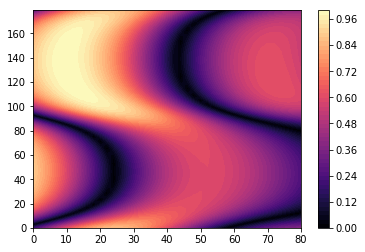

In [199]:
ll, dd = np.meshgrid(slags, degs)
plt.contourf(ll, dd, abs(rho), 50, cmap='magma')
plt.colorbar()
plt.show()


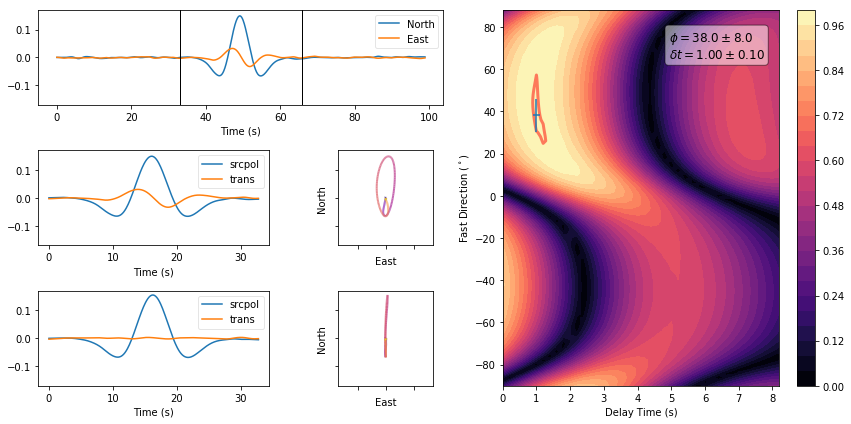

In [176]:
xc = dat.XC()
xc.plot(vals = xc.xc)

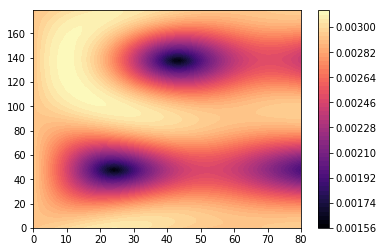

In [195]:
ll, dd = np.meshgrid(slags, degs)
plt.contourf(ll, dd, lam1, 50, cmap='magma')
plt.colorbar()
plt.show()

In [197]:
ll.shape

(180, 41)

In [ ]:
dat._parse

In [ ]:
np.convolve?

In [6]:
dat.window.asarray(100)

AttributeError: 'Window' object has no attribute 'end'

In [9]:
N = 20
np.ones((N,))/N

array([ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,
        0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,
        0.05,  0.05])

In [19]:
dat._w0() - 2/2

329.0

In [18]:
dat._w1()

659

In [28]:
np.convolve?

In [156]:
eigvals, eigvecs = np.linalg.eigh(c[:,:])

In [163]:
eigvals[:,:,0]

array([[ 0.00017179,  0.00016396,  0.00014071, ...,  0.00015749,
         0.00015389,  0.00015304],
       [ 0.00017179,  0.0001686 ,  0.00015333, ...,  0.00015984,
         0.00015618,  0.00015501],
       [ 0.00017179,  0.00017333,  0.00016662, ...,  0.00016693,
         0.00016358,  0.00016227],
       ..., 
       [ 0.00017179,  0.00015074,  0.00010718, ...,  0.00017784,
         0.00017654,  0.00017781],
       [ 0.00017179,  0.00015501,  0.00011762, ...,  0.00016665,
         0.00016423,  0.0001646 ],
       [ 0.00017179,  0.00015943,  0.0001288 , ...,  0.00015981,
         0.00015661,  0.00015629]])

In [205]:
degs = np.linspace(0, 180, 90, endpoint=False)
lags = np.linspace(0, 8, 30)
slags = np.unique(sw.core.core.time2samps(lags, dat.delta, mode='even'))
%timeit gridcov(x, y, w0, w1, degs, slags)

66.6 ms ± 487 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
